In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from read_file import *
import os

## Première procédure de résolution
### Phase I

In [2]:
## Loading data
n = 200
p = 6
filename = f"./data/2KP200-TA-0.dat"

w=np.zeros(n,dtype=int) # poids des objets
v=np.zeros((n,p),dtype=int) # utilités des objets
W = readFile(filename,w,v)

# ====== On prend un sous-ensemble du problème ====
n = 50
p = 3
w = w[:n]
v = v[:n,:p]
W = w.sum()//2
print(w.shape, v.shape, W)

(50,) (50, 3) 13299


In [3]:
## Phase I: generate non-dominated solution with PLS
params = (n,p,v,w,W)
m = 20
verbose = True
NBMAX = 20

YND = PLS(m,params,NBMAX,verbose= False)
points = list(map(lambda x: x[1], YND))
points = np.array(points)
print(f'nombre de points non-dominés trouvés: {len(points)}')

nombre de points non-dominés trouvés: 225


### Phase II: 

In [8]:
eps = 1e-4
L = []
mode = 'EU'
for epoch in range(20):
    print(f'{epoch = }')
    DM = DecisionMaker(p, mode)
    model = Model(dim=p, mode=mode)
    o1, o2, regret = model.CSS(YND)
    minmax_regrets = [regret]
    it = 1
    while regret > eps:
        if DM.ask(o1, o2): model.update(o1,o2)
        else: model.update(o2,o1)
        o1, o2, regret = model.CSS(YND)
        minmax_regrets.append(regret)
    L.append(minmax_regrets)

epoch = 0
Init EU Model
epoch = 1
Init EU Model
epoch = 2
Init EU Model
epoch = 3
Init EU Model
epoch = 4
Init EU Model
epoch = 5
Init EU Model
epoch = 6
Init EU Model
epoch = 7
Init EU Model
epoch = 8
Init EU Model
epoch = 9
Init EU Model
epoch = 10
Init EU Model
epoch = 11
Init EU Model
epoch = 12
Init EU Model
epoch = 13
Init EU Model
epoch = 14
Init EU Model
epoch = 15
Init EU Model
epoch = 16
Init EU Model
epoch = 17
Init EU Model
epoch = 18
Init EU Model
epoch = 19
Init EU Model


## Evaluation du nombre de questions nécessaires pour identifier la solution optimale pour le décideur

In [10]:
sizes = [len(x) for x in L]
print(np.mean(sizes))

10.45


In [11]:
sizes

[15, 13, 9, 12, 10, 8, 9, 9, 15, 7, 15, 10, 5, 5, 12, 10, 10, 10, 15, 10]

## Variation du regret minimax en fonction du nombre de questions posées

Text(0, 0.5, 'minimax regret')

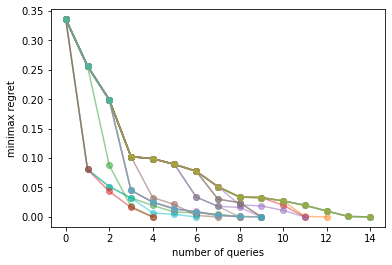

In [14]:
for regrets in L:
    plt.plot(regrets, 'o-', alpha=0.5)
plt.xlabel('number of queries')
plt.ylabel('minimax regret')

Text(0, 0.5, 'minimax regret')

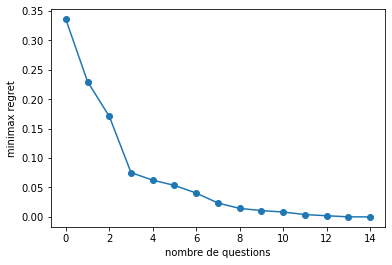

In [24]:
mean_regrets = np.zeros((len(sizes),max(sizes)))
for i,regrets in enumerate(L):
    mean_regrets[i,:len(regrets)] = regrets

plt.plot(mean_regrets.mean(0), 'o-')
plt.xlabel('nombre de questions')
plt.ylabel('minimax regret')

In [25]:
L = np.array(L)

/var/folders/yd/v7_2g2ys6dlc_jwd4rjdgsj00000gn/T/ipykernel_55391/1368715817.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  L = np.array(L)


In [29]:
np.savetxt('minmax_regrets',mean_regrets)